### **Prepare Dataset**

In [1]:
import pandas as pd


def load_dataset(file_path, timesteps=5):
    df = pd.read_excel(file_path)

    # Perform min-max normalization on column 'A'
    min_value = df['A'].min()
    max_value = df['A'].max()

    df['A'] = (df['A'] - min_value) / (max_value - min_value)

    # Create new columns for the next time steps
    if timesteps == 5:
      df['B'] = df['A'].shift(-1)
      df['C'] = df['A'].shift(-2)
      df['D'] = df['A'].shift(-3)
      df['E'] = df['A'].shift(-4)
      df['F'] = df['A'].shift(-5)
    if timesteps == 8:
      df['B'] = df['A'].shift(-1)
      df['C'] = df['A'].shift(-2)
      df['D'] = df['A'].shift(-3)
      df['E'] = df['A'].shift(-4)
      df['F'] = df['A'].shift(-5)
      df['G'] = df['A'].shift(-6)
      df['H'] = df['A'].shift(-7)
      df['I'] = df['A'].shift(-8)

    # Drop the rows with missing values
    df = df.dropna()

    # Convert the DataFrame to a NumPy array
    numpy_array = df.values

    return numpy_array

### **Define LSTM Model**

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(output):
    return output * (1 - output)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(output):
    return 1 - output ** 2

# Mean Squared Error loss and its derivative
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.Wf = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size)
        self.bf = np.zeros(hidden_size)
        self.bi = np.zeros(hidden_size)
        self.bo = np.zeros(hidden_size)
        self.bc = np.zeros(hidden_size)
        self.Wy = np.random.randn(1, hidden_size)
        self.by = np.zeros(1)

    def forward(self, x, h_prev, c_prev):
        self.x, self.h_prev, self.c_prev = x, h_prev, c_prev
        self.combined = np.hstack((h_prev, x))
        self.f = sigmoid(np.dot(self.Wf, self.combined) + self.bf)
        self.i = sigmoid(np.dot(self.Wi, self.combined) + self.bi)
        self.o = sigmoid(np.dot(self.Wo, self.combined) + self.bo)
        self.c_hat = tanh(np.dot(self.Wc, self.combined) + self.bc)
        self.c = self.f * c_prev + self.i * self.c_hat
        self.h = self.o * tanh(self.c)
        self.y_pred = np.dot(self.Wy, self.h) + self.by
        return self.y_pred, self.h, self.c

    def backward(self, dL_dy, dh_next, dc_next, learning_rate):
        dy_dh = self.Wy
        dh = np.dot(dy_dh.T, dL_dy) + dh_next
        dc = dh * self.o * tanh_derivative(tanh(self.c)) + dc_next

        df = dc * self.c_prev * sigmoid_derivative(self.f)
        di = dc * self.c_hat * sigmoid_derivative(self.i)
        do = dh * tanh(self.c) * sigmoid_derivative(self.o)
        dc_hat = dc * self.i * tanh_derivative(self.c_hat)

        dWf = np.dot(df.reshape(-1, 1), self.combined.reshape(1, -1))
        dWi = np.dot(di.reshape(-1, 1), self.combined.reshape(1, -1))
        dWo = np.dot(do.reshape(-1, 1), self.combined.reshape(1, -1))
        dWc = np.dot(dc_hat.reshape(-1, 1), self.combined.reshape(1, -1))

        dbf = df
        dbi = di
        dbo = do
        dbc = dc_hat

        dWy = np.dot(dL_dy, self.h.reshape(1, -1))
        dby = dL_dy

        # Update weights and biases
        self.Wf -= learning_rate * dWf
        self.Wi -= learning_rate * dWi
        self.Wo -= learning_rate * dWo
        self.Wc -= learning_rate * dWc
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc
        self.Wy -= learning_rate * dWy
        self.by -= learning_rate * dby.reshape(-1)

        dcombined = np.dot(self.Wf.T, df) + np.dot(self.Wi.T, di) + np.dot(self.Wo.T, do) + np.dot(self.Wc.T, dc_hat)
        dh_prev = dcombined[:self.hidden_size]
        dc_prev = dc * self.f

        return dh_prev, dc_prev

Train on ECG Dataset, Timestep=5

Epoch:  1
Train MSE:  0.02948594503520036 Test MSE:  0.012017057125222436
Epoch:  2
Train MSE:  0.0036822517270076642 Test MSE:  0.008150181829432595
Epoch:  3
Train MSE:  0.002622657820968327 Test MSE:  0.007093813058536221
Epoch:  4
Train MSE:  0.0023138947723966717 Test MSE:  0.006602899438617846
Epoch:  5
Train MSE:  0.002145320439084614 Test MSE:  0.006257499650734983
Epoch:  6
Train MSE:  0.002016139050309082 Test MSE:  0.00595952222525145
Epoch:  7
Train MSE:  0.0019038333634030101 Test MSE:  0.005683423077031553
Epoch:  8
Train MSE:  0.0018021216643413504 Test MSE:  0.005422179523870823
Epoch:  9
Train MSE:  0.0017087584877305986 Test MSE:  0.005173688503126093
Epoch:  10
Train MSE:  0.0016226090181994098 Test MSE:  0.004937156505816475
Epoch:  11
Train MSE:  0.0015428895821493873 Test MSE:  0.0047121288224889835
Epoch:  12
Train MSE:  0.0014689628025265473 Test MSE:  0.004498228988214541
Epoch:  13
Train MSE:  0.001400278446095813 Test MSE:  0.0042950901526407105
Epoch:  14
Tr

Train MSE:  0.00017267631795112422 Test MSE:  0.00038935242696023933
Epoch:  108
Train MSE:  0.0001709458291328662 Test MSE:  0.0003840749713338347
Epoch:  109
Train MSE:  0.00016925620037730075 Test MSE:  0.00037891708204781114
Epoch:  110
Train MSE:  0.00016760627805708595 Test MSE:  0.0003738752714580931
Epoch:  111
Train MSE:  0.00016599494808878436 Test MSE:  0.0003689461813946166
Epoch:  112
Train MSE:  0.00016442113425077504 Test MSE:  0.0003641265773752694
Epoch:  113
Train MSE:  0.00016288379658757046 Test MSE:  0.0003594133431150584
Epoch:  114
Train MSE:  0.0001613819298954426 Test MSE:  0.000354803475316497
Epoch:  115
Train MSE:  0.00015991456228461556 Test MSE:  0.0003502940787231761
Epoch:  116
Train MSE:  0.00015848075381361546 Test MSE:  0.0003458823614214544
Epoch:  117
Train MSE:  0.00015707959519160647 Test MSE:  0.00034156563037652957
Epoch:  118
Train MSE:  0.00015571020654489226 Test MSE:  0.00033734128719060675
Epoch:  119
Train MSE:  0.00015437173624386597 Test

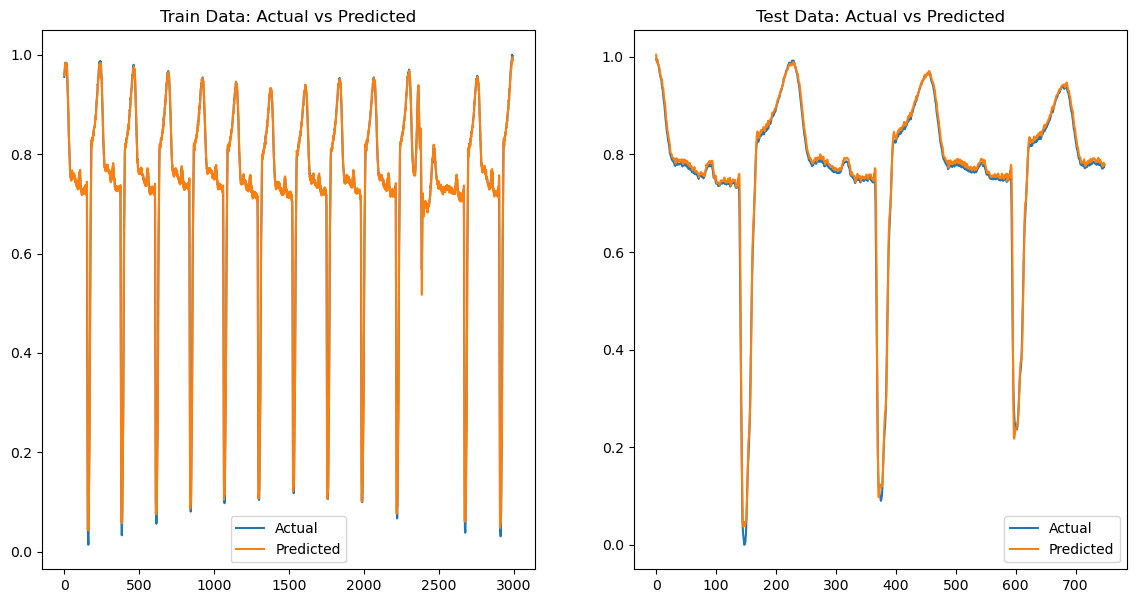

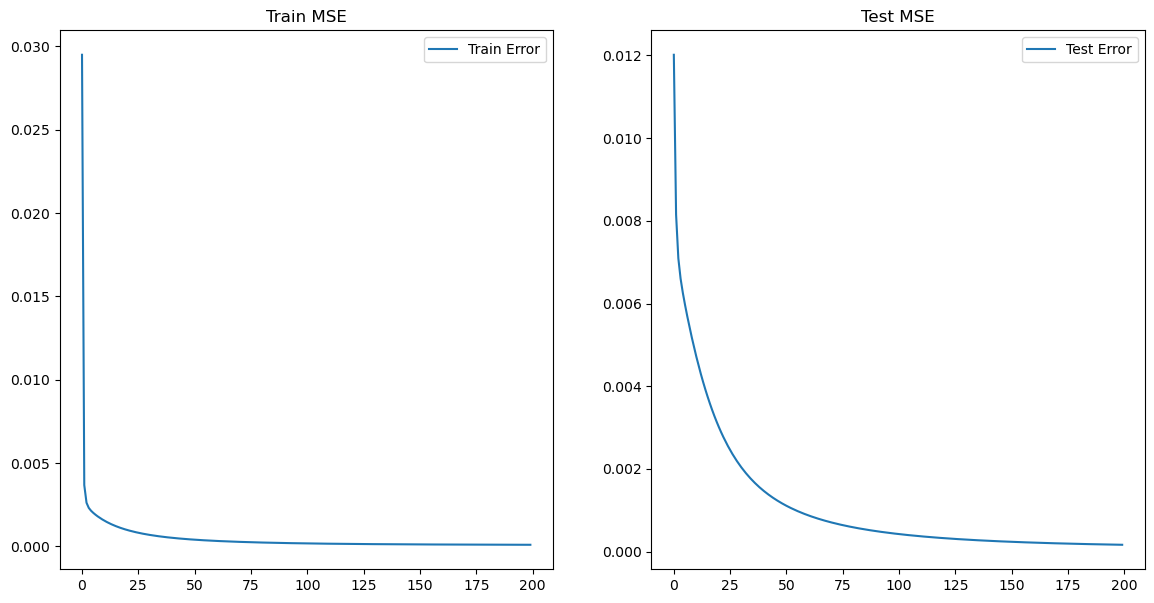

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


np.random.seed(42)
# Initialize parameters
input_size = 1
hidden_size = 4
learning_rate = 0.001
epochs=200
# Load data from the Excel file
file_path = ['ECG Datasets.xlsx']
timesteps = [5, 8]
numpy_array = load_dataset(file_path[0], timesteps[0])

# Initialize LSTM cells
forward_lstm_cell = LSTMCell(input_size, hidden_size)
backward_lstm_cell = LSTMCell(input_size, hidden_size)

# Split data into input X and output Y
X = numpy_array[:, :-1]
Y = numpy_array[:, -1]
split_index = int(0.8 * len(X))
X_train_seq, Y_train_seq = X[:split_index], Y[:split_index]
X_test_seq, Y_test_seq = X[split_index:], Y[split_index:]

train_predictions = []
test_predictions = []

forward_h, forward_c = np.zeros(hidden_size), np.zeros(hidden_size)
backward_h, backward_c = np.zeros(hidden_size), np.zeros(hidden_size)

train_errors = []
test_errors = []

# Training loop
for epoch in range(epochs):
    print("Epoch: ", epoch+1)
    train_predictions = []
    test_predictions = []
    # train the model
    for t in range(len(X_train_seq)):
        x_seq, y_true = X_train_seq[t], Y_train_seq[t]
        for x in x_seq:
            forward_y_pred, forward_h, forward_c = forward_lstm_cell.forward(x, forward_h, forward_c)
        for x in reversed(x_seq):
            backward_y_pred, backward_h, backward_c = backward_lstm_cell.forward(x,backward_h, backward_c)

        y_pred = forward_y_pred + backward_y_pred
        train_predictions.append(y_pred.item())
        dL_dy = mse_loss_derivative(y_true, y_pred)
        forward_dh_next = np.zeros_like(forward_h)
        forward_dc_next = np.zeros_like(forward_c)
        backward_dh_next = np.zeros_like(backward_h)
        backward_dc_next = np.zeros_like(backward_c)
        for x in reversed(x_seq):
            forward_dh_prev, forward_dc_prev = forward_lstm_cell.backward(dL_dy, \
                                          forward_dh_next, forward_dc_next, learning_rate)
            forward_dh_next, forward_dc_next = forward_dh_prev, forward_dc_prev
        for x in x_seq:
            backward_dh_prev, backward_dc_prev = backward_lstm_cell.backward(dL_dy,\
                                            backward_dh_next, backward_dc_next, learning_rate)
            backward_dh_next, backward_dc_next = backward_dh_prev, backward_dc_prev

    # test the model
    forward_h, forward_c = np.zeros(hidden_size), np.zeros(hidden_size)
    backward_h, backward_c = np.zeros(hidden_size), np.zeros(hidden_size)
    for t in range(len(X_test_seq)):
        x_seq, y_true = X_test_seq[t], Y_test_seq[t]
        for x in x_seq:
          forward_y_pred, forward_h, forward_c = forward_lstm_cell.forward(x, forward_h, forward_c)
        for x in reversed(x_seq):
          backward_y_pred, backward_h, backward_c = backward_lstm_cell.forward(x, backward_h, backward_c)
        y_pred = forward_y_pred + backward_y_pred
        test_predictions.append(y_pred.item())

    # compute train error per epoch
    train_error = mse_loss(Y_train_seq, train_predictions)
    train_errors.append(train_error)

    # compute test error per epoch
    test_error = mse_loss(Y_test_seq, test_predictions)
    test_errors.append(test_error)
    print("Train MSE: ", train_error, "Test MSE: ", test_error)

# Plotting train predictions vs actual data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(Y_train_seq)), Y_train_seq, label="Actual")
plt.plot(np.arange(len(train_predictions)), train_predictions, label="Predicted", linestyle='-')
plt.title("Train Data: Actual vs Predicted")
plt.legend()

# Plotting test predictions vs actual data
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(Y_test_seq)), Y_test_seq, label="Actual")
plt.plot(np.arange(len(test_predictions)), test_predictions, label="Predicted", linestyle='-')
plt.title("Test Data: Actual vs Predicted")
plt.legend()
plt.show()


# Plotting Train MSE
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), train_errors, label="Train Error")
plt.title("Train MSE")
plt.legend()

# Plotting Test MSE
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), test_errors, label="Test Error")
plt.title("Test MSE")
plt.legend()
plt.show()


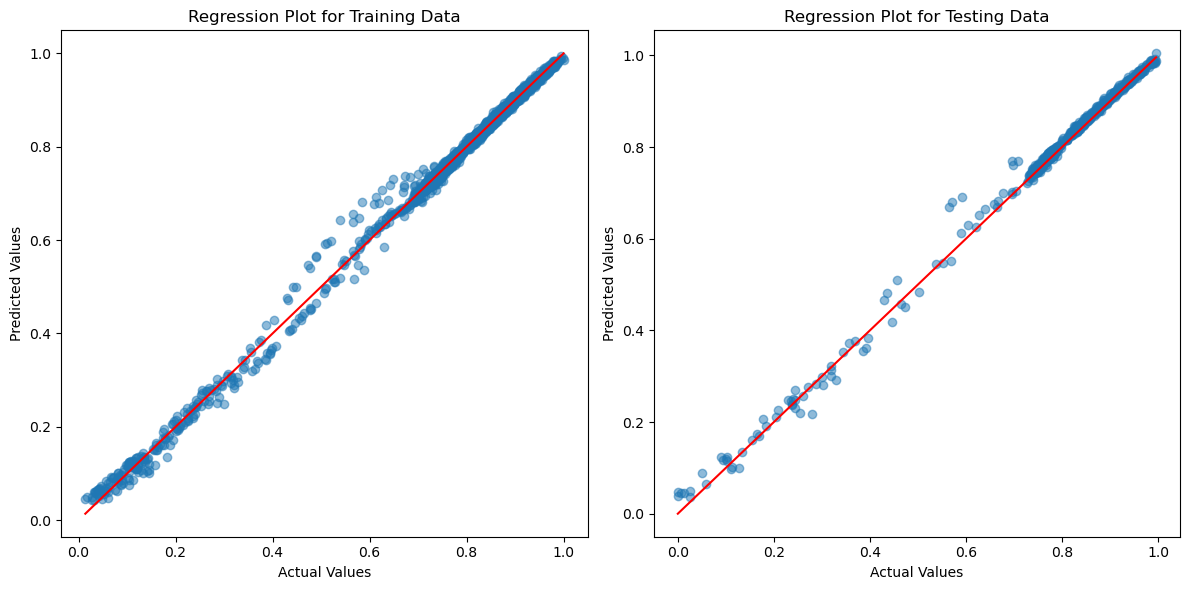

In [ ]:
import matplotlib.pyplot as plt


# Plot regression for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Y_train_seq, train_predictions, alpha=0.5)
plt.title("Regression Plot for Training Data")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(Y_train_seq), max(Y_train_seq)], [min(Y_train_seq), max(Y_train_seq)], color='red')

# Plot regression for testing data
plt.subplot(1, 2, 2)
plt.scatter(Y_test_seq, test_predictions, alpha=0.5)
plt.title("Regression Plot for Testing Data")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(Y_test_seq), max(Y_test_seq)], [min(Y_test_seq), max(Y_test_seq)], color='red')

plt.tight_layout()
plt.show()


Train on ECG Dataset, Timestep=8


Epoch:  1
Train MSE:  0.013467185994339612 Test MSE:  0.0027978483883275428
Epoch:  2
Train MSE:  0.000984302810911573 Test MSE:  0.0010675069975848643
Epoch:  3
Train MSE:  0.0006037560192528059 Test MSE:  0.0008375217934729524
Epoch:  4
Train MSE:  0.0004996156088937706 Test MSE:  0.0008097301207357299
Epoch:  5
Train MSE:  0.00046279964103277196 Test MSE:  0.0007903639926277096
Epoch:  6
Train MSE:  0.00044489803640874326 Test MSE:  0.0007664182883675438
Epoch:  7
Train MSE:  0.0004333116022588187 Test MSE:  0.0007439282355292551
Epoch:  8
Train MSE:  0.0004244339500711423 Test MSE:  0.0007257397894810439
Epoch:  9
Train MSE:  0.00041706304073892164 Test MSE:  0.0007119506503687149
Epoch:  10
Train MSE:  0.0004107112003311106 Test MSE:  0.0007017286596267882
Epoch:  11
Train MSE:  0.0004051367591776056 Test MSE:  0.0006941625722108633
Epoch:  12
Train MSE:  0.00040019658941793434 Test MSE:  0.0006885134983641215
Epoch:  13
Train MSE:  0.0003957925964220429 Test MSE:  0.0006842379017

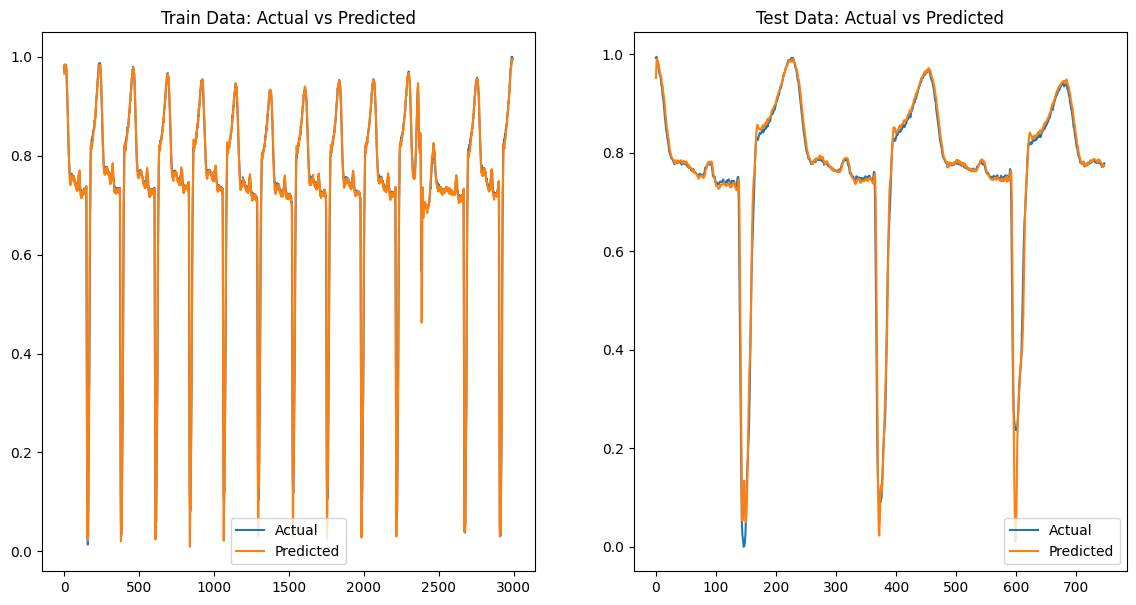

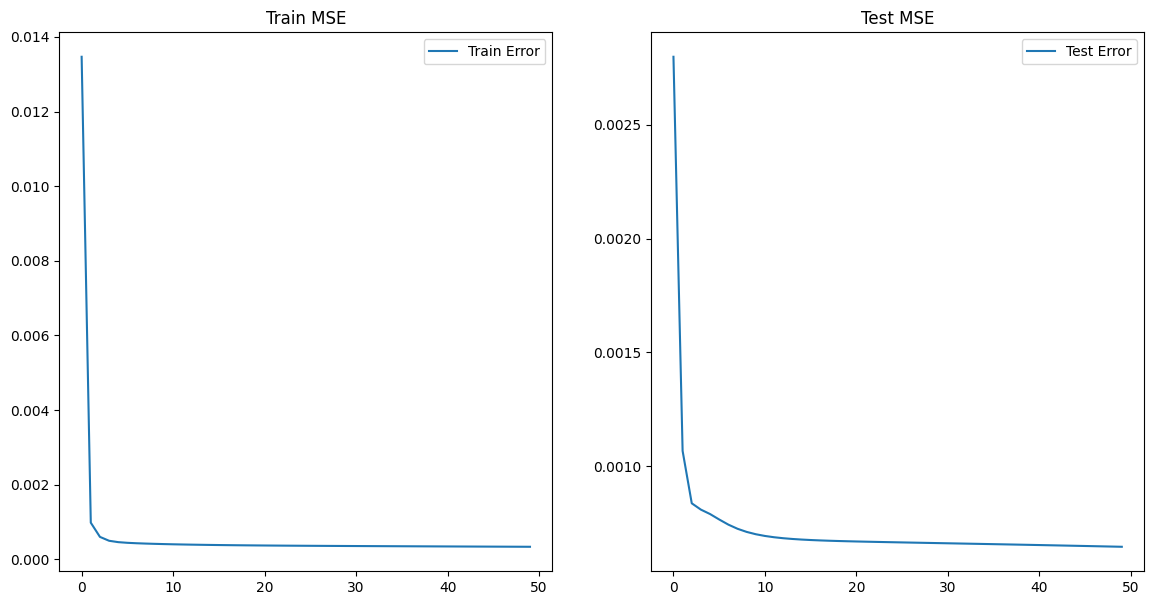

In [3]:
import matplotlib.pyplot as plt
import numpy as np


np.random.seed(42)
# Initialize parameters
input_size = 1
hidden_size = 5
learning_rate = 0.001
epochs=50
# Load data from the Excel file
file_path = ['ECG Datasets.xlsx']
timesteps = [5, 8]
numpy_array = load_dataset(file_path[0], timesteps[1])

# Initialize LSTM cells
forward_lstm_cell = LSTMCell(input_size, hidden_size)
backward_lstm_cell = LSTMCell(input_size, hidden_size)

# Split data into input X and output Y
X = numpy_array[:, :-1]
Y = numpy_array[:, -1]
split_index = int(0.8 * len(X))
X_train_seq, Y_train_seq = X[:split_index], Y[:split_index]
X_test_seq, Y_test_seq = X[split_index:], Y[split_index:]

train_predictions = []
test_predictions = []

forward_h, forward_c = np.zeros(hidden_size), np.zeros(hidden_size)
backward_h, backward_c = np.zeros(hidden_size), np.zeros(hidden_size)

train_errors = []
test_errors = []

# Training loop
for epoch in range(epochs):
    print("Epoch: ", epoch+1)
    train_predictions = []
    test_predictions = []
    for t in range(len(X_train_seq)):
        x_seq, y_true = X_train_seq[t], Y_train_seq[t]
        for x in x_seq:
            forward_y_pred, forward_h, forward_c = forward_lstm_cell.forward(x, forward_h, forward_c)
        for x in reversed(x_seq):
            backward_y_pred, backward_h, backward_c = backward_lstm_cell.forward(x,backward_h, backward_c)

        y_pred = forward_y_pred + backward_y_pred
        train_predictions.append(y_pred.item())
        dL_dy = mse_loss_derivative(y_true, y_pred)
        forward_dh_next = np.zeros_like(forward_h)
        forward_dc_next = np.zeros_like(forward_c)
        backward_dh_next = np.zeros_like(backward_h)
        backward_dc_next = np.zeros_like(backward_c)
        for x in reversed(x_seq):
            forward_dh_prev, forward_dc_prev = forward_lstm_cell.backward(dL_dy, \
                                          forward_dh_next, forward_dc_next, learning_rate)
            forward_dh_next, forward_dc_next = forward_dh_prev, forward_dc_prev
        for x in x_seq:
            backward_dh_prev, backward_dc_prev = backward_lstm_cell.backward(dL_dy,\
                                            backward_dh_next, backward_dc_next, learning_rate)
            backward_dh_next, backward_dc_next = backward_dh_prev, backward_dc_prev

    forward_h, forward_c = np.zeros(hidden_size), np.zeros(hidden_size)
    backward_h, backward_c = np.zeros(hidden_size), np.zeros(hidden_size)
    for t in range(len(X_test_seq)):
        x_seq, y_true = X_test_seq[t], Y_test_seq[t]
        for x in x_seq:
          forward_y_pred, forward_h, forward_c = forward_lstm_cell.forward(x, forward_h, forward_c)
        for x in reversed(x_seq):
          backward_y_pred, backward_h, backward_c = backward_lstm_cell.forward(x, backward_h, backward_c)
        y_pred = forward_y_pred + backward_y_pred
        test_predictions.append(y_pred.item())

    # compute train error per epoch
    train_error = mse_loss(Y_train_seq, train_predictions)
    train_errors.append(train_error)

    # compute test error per epoch
    test_error = mse_loss(Y_test_seq, test_predictions)
    test_errors.append(test_error)
    print("Train MSE: ", train_error, "Test MSE: ", test_error)

# Plotting train predictions vs actual data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(Y_train_seq)), Y_train_seq, label="Actual")
plt.plot(np.arange(len(train_predictions)), train_predictions, label="Predicted", linestyle='-')
plt.title("Train Data: Actual vs Predicted")
plt.legend()

# Plotting test predictions vs actual data
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(Y_test_seq)), Y_test_seq, label="Actual")
plt.plot(np.arange(len(test_predictions)), test_predictions, label="Predicted", linestyle='-')
plt.title("Test Data: Actual vs Predicted")
plt.legend()
plt.show()


# Plotting Train MSE
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), train_errors, label="Train Error")
plt.title("Train MSE")
plt.legend()

# Plotting Test MSE
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), test_errors, label="Test Error")
plt.title("Test MSE")
plt.legend()
plt.show()


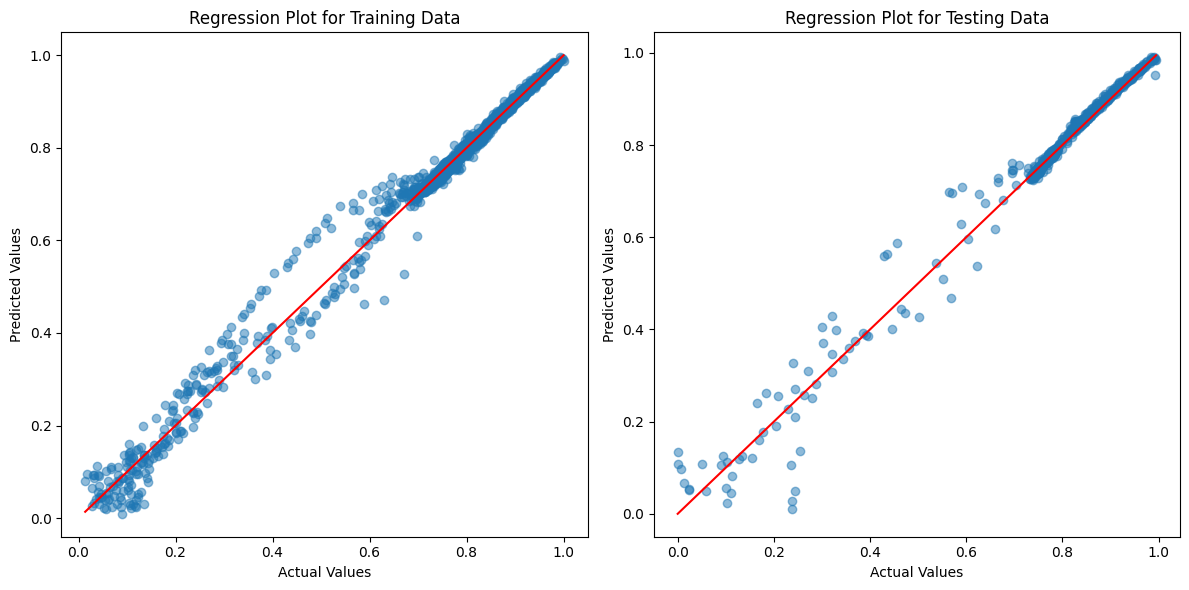

In [4]:
import matplotlib.pyplot as plt


# Plot regression for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Y_train_seq, train_predictions, alpha=0.5)
plt.title("Regression Plot for Training Data")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(Y_train_seq), max(Y_train_seq)], [min(Y_train_seq), max(Y_train_seq)], color='red')

# Plot regression for testing data
plt.subplot(1, 2, 2)
plt.scatter(Y_test_seq, test_predictions, alpha=0.5)
plt.title("Regression Plot for Testing Data")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(Y_test_seq), max(Y_test_seq)], [min(Y_test_seq), max(Y_test_seq)], color='red')

plt.tight_layout()
plt.show()
